# Deep Convolutional Autoencoders for Clustering images.

In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K
from keras.callbacks import TensorBoard

from IPython.display import Image, SVG
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from time import time

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# transform 2D 28x28 matrix to 3D (28x28x1) tensor
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) 
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#inputs have to be between [0, 1]
x_train /= 255 
x_test /= 255

In [4]:
model = Sequential()

# 1st convolution layer
# 16 filters of size (3, 3) 
model.add(Conv2D(16, (3, 3) 
    , padding='same', input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# 2nd convolution layer
# 2 filters of size (3, 3) 
model.add(Conv2D(2,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#-------------------------

# 3rd convolution layer
# 2 filters of size (3, 3) for upsampling
model.add(Conv2D(2,(3, 3), padding='same')) # apply 2 filters sized of (3x3)
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#4th convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#-------------------------


model.add(Conv2D(1,(3, 3), padding='same'))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 2)         290       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 2)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 2)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 2)           38        
__________

In [5]:
tb_callback = TensorBoard(log_dir='./logs/{}'.format(time()), histogram_freq=0, write_graph=True, write_images=True)

model.compile(optimizer='adadelta', loss='binary_crossentropy')
model.fit(x_train, x_train, 
          epochs=3,
          validation_data=(x_test, x_test),
          callbacks = [tb_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 14s 237us/step - loss: 0.1363 - val_loss: 0.1064
Epoch 2/3
60000/60000 [==============================] - 12s 207us/step - loss: 0.0996 - val_loss: 0.0941
Epoch 3/3
60000/60000 [==============================] - 12s 202us/step - loss: 0.0955 - val_loss: 0.0914


In [6]:
restored_imgs = model.predict(x_test)

actual validation image


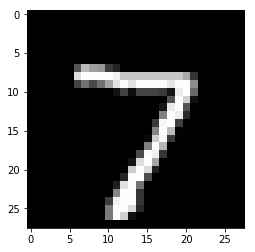

restored image


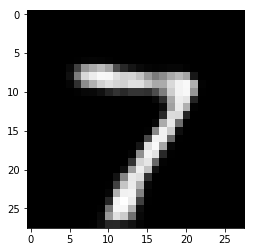

-----------------------
actual validation image


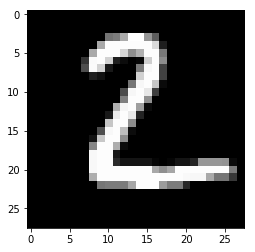

restored image


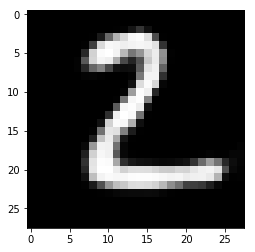

-----------------------
actual validation image


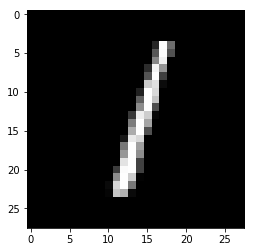

restored image


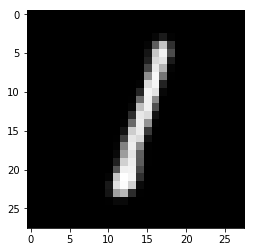

-----------------------
actual validation image


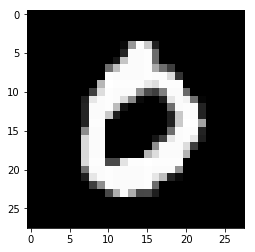

restored image


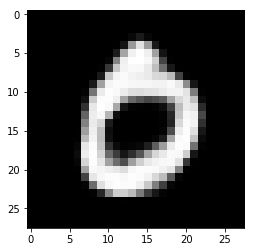

-----------------------
actual validation image


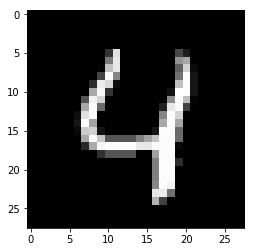

restored image


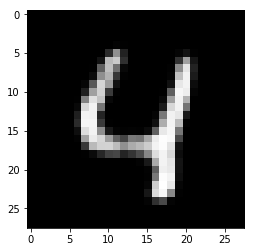

-----------------------


In [7]:
for i in range(5):
    print("actual validation image")
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    plt.show()
    
    print("restored image")
    plt.imshow(restored_imgs[i].reshape(28, 28))
    plt.gray()
    plt.show()
    
    print("-----------------------")

In [8]:
#layer[7] is activation_3 (Activation), it is compressed representation
get_3rd_layer_output = K.function([model.layers[0].input], [model.layers[7].output])
compressed = get_3rd_layer_output([x_test])[0]

In [9]:
#layer[7] is size of (None, 7, 7, 2). this means 2 different 7x7 sized matrixes. We will flatten these matrixes.
compressed = compressed.reshape(10000,7*7*2)

In [11]:
from tensorflow.contrib.factorization.python.ops import clustering_ops
import tensorflow as tf

In [40]:
tf.__version__

'1.10.0'

In [31]:
# k value being 10 for creating 10 clusters
kmeans = tf.contrib.factorization.KMeansClustering(num_clusters=10,
                                                   distance_metric = 'squared_euclidean',
                                                   initial_clusters= 'random')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_device_fn': None, '_save_checkpoints_secs': 600, '_global_id_in_cluster': 0, '_evaluation_master': '', '_is_chief': True, '_train_distribute': None, '_session_config': None, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E69401CEF0>, '_num_ps_replicas': 0, '_model_dir': 'C:\\Users\\SYMPHO~1\\AppData\\Local\\Temp\\tmp1d4z8n5z', '_master': '', '_num_worker_replicas': 1, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_task_type': 'worker', '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_keep_checkpoint_max': 5}


In [22]:
def train_input_fn():
    data = tf.constant(compressed, tf.float32)
    return (data, None)

In [32]:
kmeans.train(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\SYMPHO~1\AppData\Local\Temp\tmp1d4z8n5z\model.ckpt.
INFO:tensorflow:loss = 255384.83, step = 1
INFO:tensorflow:global_step/sec: 7.25084
INFO:tensorflow:loss = 147584.77, step = 101 (13.792 sec)
INFO:tensorflow:global_step/sec: 7.17738
INFO:tensorflow:loss = 146752.31, step = 201 (13.933 sec)
INFO:tensorflow:global_step/sec: 7.61291
INFO:tensorflow:loss = 146316.53, step = 301 (13.136 sec)
INFO:tensorflow:global_step/sec: 7.17993
INFO:tensorflow:loss = 146068.9, step = 401 (13.928 sec)
INFO:tensorflow:global_step/sec: 7.47793
INFO:tensorflow:loss = 145910.64, step = 501 (13.372 sec)
INFO:tensorflow:global_step/sec: 7.59627
INFO:tensorflow:loss = 145800.1, step = 601 (13.164 sec)
INFO:tensorflow:globa

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\SYMPHO~1\AppData\Local\Temp\tmp1d4z8n5z\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


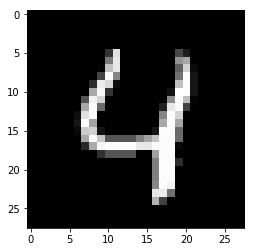

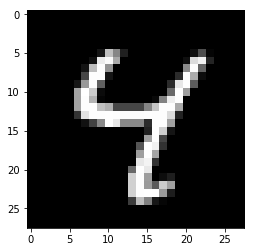

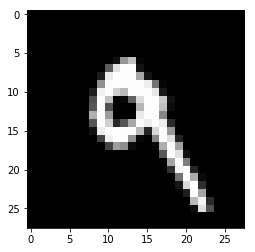

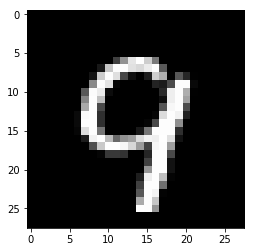

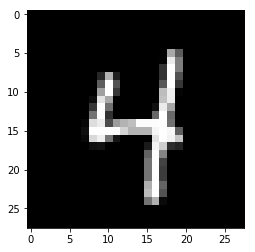

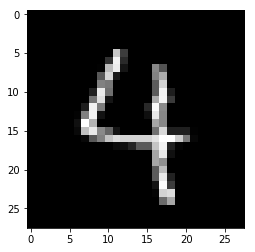

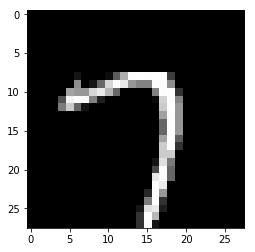

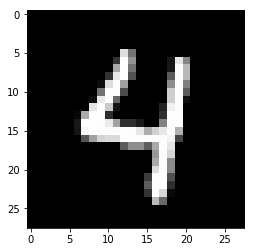

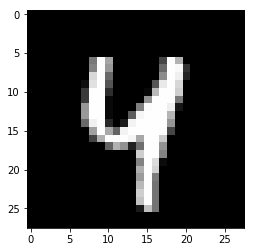

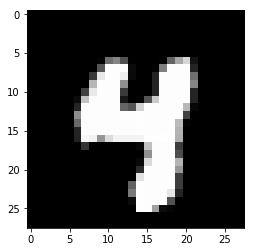

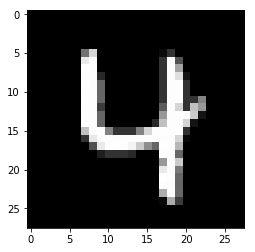

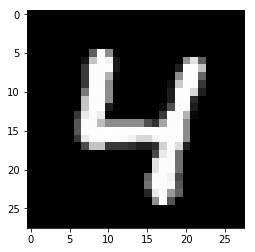

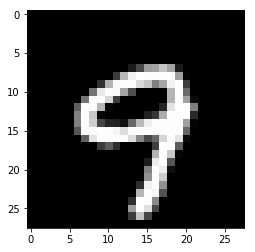

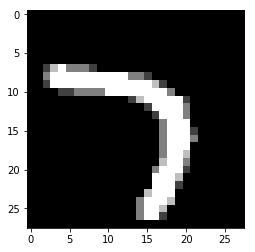

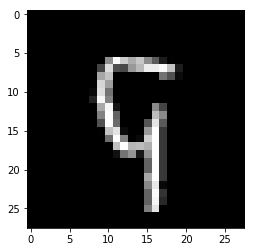

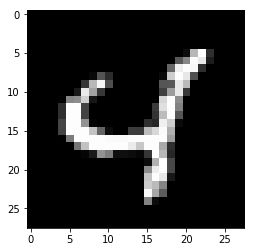

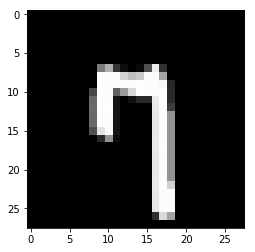

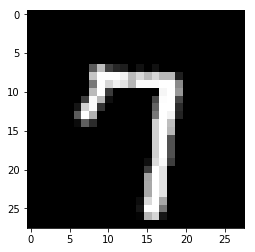

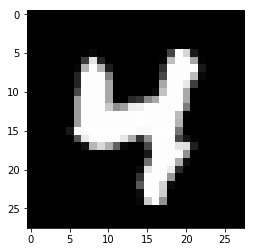

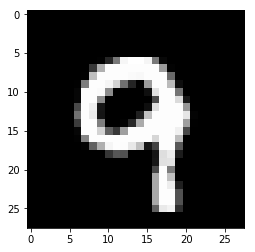

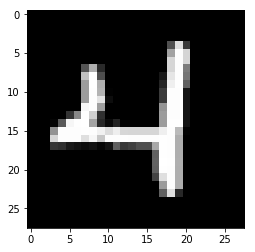

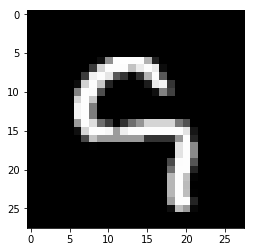

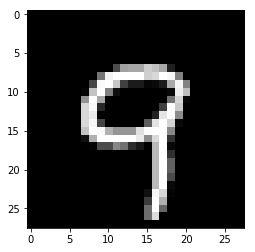

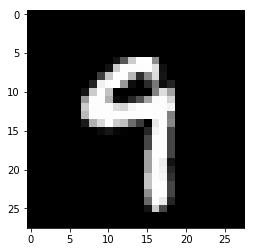

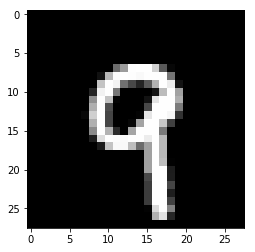

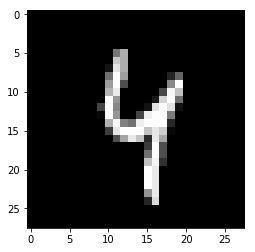

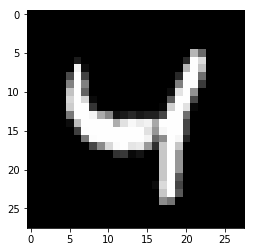

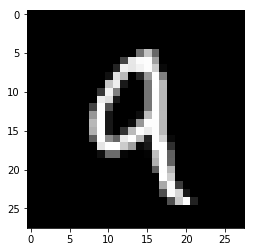

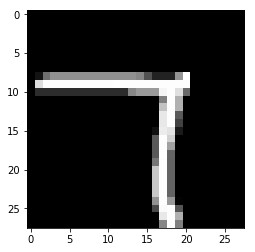

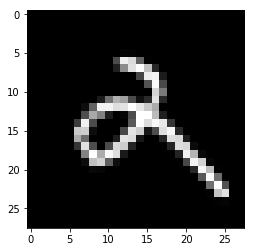

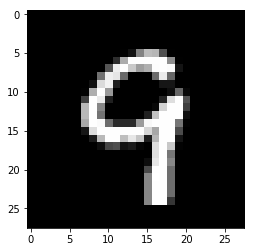

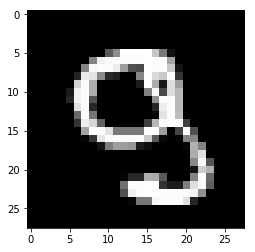

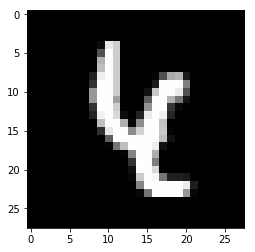

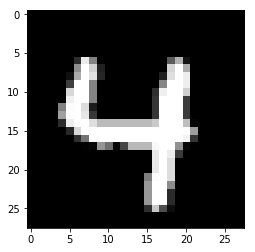

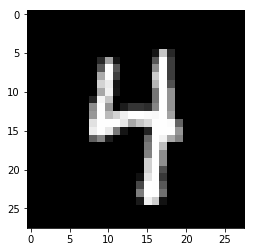

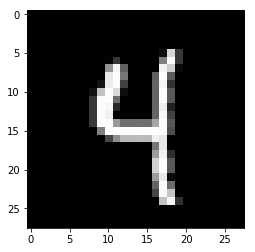

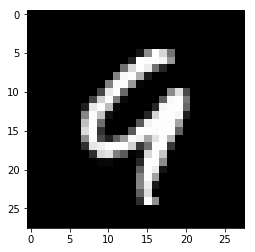

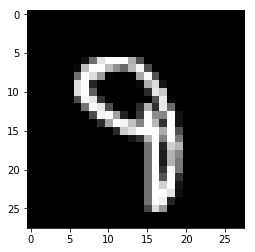

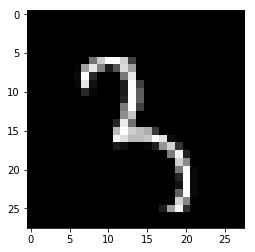

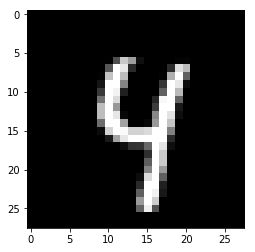

IndexError: index 10000 is out of bounds for axis 0 with size 10000

In [39]:
clusters = kmeans.predict(input_fn=train_input_fn)

index = 0
for i in clusters:
    current_cluster = i['cluster_index']
    features = x_test[index]
    
    if index < 200 and current_cluster == 5:
        plt.imshow(x_test[index].reshape(28, 28))
        plt.gray()
        plt.show()
    index = index + 1

This cluster `5` (NOT related to the number 5 from MNIST) we can see it's trying to cluster based on shapes, all the figures either have a single stroke on right-middle side, like in 1, 7, 9, 4 also tries to find have in between lines like 8, 5, 4.

## What did we achieve?

Instead of having 784 featuers (28 x 28) for clustering we are having only 98 features (7 x 2 x 2), ~ **87.25 % decrease in no. of features**  -> Learned represenations from the encoding layer, we are able to cluster them. Thus having a feature reduction technique by automatically learning the necessary representations which can be used for large scale clustering.